In [1]:
# ==========================================
# 0. Імпорт бібліотек
# ==========================================
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

# Визначаємо, де будемо рахувати: GPU (cuda), якщо доступний, інакше CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
# ==========================================
# 1. Завантаження даних
# ==========================================
# Вкажи шлях до папки з файлами Kaggle Titanic
data_dir = r"C:\Users\ischur\Desktop\Data Science\Titanic"
train_path = os.path.join(data_dir, "train.csv")

# Читаємо train.csv у DataFrame
df = pd.read_csv(train_path)

# Поглянемо на перші рядки
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# ==========================================
# 2. Препроцесинг даних
# ==========================================
# Робимо копію, щоб не псувати оригінальний df
data = df.copy()

# 2.1. Заповнюємо пропущені значення
# Age: заповнюємо медіаною
data["Age"] = data["Age"].fillna(data["Age"].median())

# Fare: теж заповнюємо медіаною (на випадок, якщо є пропуски)
data["Fare"] = data["Fare"].fillna(data["Fare"].median())

# Embarked: заповнюємо модою (найчастіше значення)
data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])

# 2.2. Кодуємо стать: male -> 1, female -> 0
data["Sex"] = data["Sex"].map({"male": 1, "female": 0})

# 2.3. Робимо one-hot encoding для Embarked (S, C, Q)
# drop_first=True означає, що одну категорію викидаємо, щоб уникнути мультиколінеарності
data = pd.get_dummies(data, columns=["Embarked"], drop_first=True)

# 2.4. Вибираємо фічі, які будемо подавати в модель
feature_cols = [
    "Pclass",      # клас квитка (1, 2, 3)
    "Sex",         # стать (0/1)
    "Age",         # вік
    "SibSp",       # кількість братів/сестер/чоловіків/дружин
    "Parch",       # кількість батьків/дітей на борту
    "Fare",        # вартість квитка
    "Embarked_Q",  # порт посадки Q (0/1)
    "Embarked_S"   # порт посадки S (0/1), C відображається коли обидва 0
]

# X — матриця ознак, y — таргет (Survived)
X = data[feature_cols].values
y = data["Survived"].values

# Розбиваємо на train/val з фіксованим random_state і стратифікацією по y
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)


Train shape: (712, 8) Val shape: (179, 8)


In [4]:
# ==========================================
# 3. Масштабування (StandardScaler)
# ==========================================
# MLP чутливий до масштабу фіч, тому нормалізуємо їх до ~N(0,1)
scaler = StandardScaler()

# Навчаємо scaler на train і застосовуємо до train/val
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

print("Приклад першого рядка до/після масштабування:")
print("До :", X_train[0])
print("Після:", X_train_scaled[0])


Приклад першого рядка до/після масштабування:
До : [3 1 28.0 0 0 56.4958 False True]
Після: [ 0.82956755  0.74242727 -0.11207776 -0.46508428 -0.46618317  0.5138115
 -0.28933346  0.61197825]


In [5]:
# ==========================================
# 4. Перетворення в PyTorch тензори
# ==========================================
# Перетворюємо numpy -> torch.tensor і переносимо на device (CPU/GPU)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
# .view(-1, 1) робить y вектор-стовпчик (N x 1), що зручно для BCE втрати

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

X_train_tensor.shape, y_train_tensor.shape


(torch.Size([712, 8]), torch.Size([712, 1]))

In [8]:
# ==========================================
# 5. Dataset і DataLoader
# ==========================================
from torch.utils.data import Dataset, DataLoader

class TitanicDataset(Dataset):
    """
    Простий Dataset для нашого табличного датасету.
    Повертає (X[i], y[i]) за індексом.
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        # Кількість зразків
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        # Один зразок (фічі, таргет)
        return self.X[idx], self.y[idx]

# Створюємо train/val датасети
train_dataset = TitanicDataset(X_train_tensor, y_train_tensor)
val_dataset   = TitanicDataset(X_val_tensor, y_val_tensor)

# DataLoader-и: розбивають на батчі, перемішують train
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [9]:
# ==========================================
# 6. Опис MLP-моделі в PyTorch
# ==========================================
class TitanicMLP(nn.Module):
    """
    Простий MLP для бінарної класифікації:
    Input -> Linear -> ReLU -> Linear -> ReLU -> Linear -> Sigmoid
    Останній Sigmoid дає ймовірність виживання (0..1).
    """
    def __init__(self, input_dim, hidden1=32, hidden2=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1),
            nn.Sigmoid()  # виходить значення в діапазоні (0,1) — ймовірність
        )
    
    def forward(self, x):
        return self.net(x)

# Визначаємо розмір вхідного шару = кількість фіч
input_dim = X_train_tensor.shape[1]

# Створюємо екземпляр моделі і переносимо на device
model = TitanicMLP(input_dim).to(device)
model


TitanicMLP(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [10]:
# ==========================================
# 7. Функція втрат і оптимізатор
# ==========================================
# Для бінарної класифікації з Sigmoid на виході — BCELoss (Binary Cross-Entropy Loss)
criterion = nn.BCELoss()

# Adam — популярний оптимізатор для нейронок
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
# ==========================================
# 8. Тренувальний цикл
# ==========================================
num_epochs = 50  # можна збільшити/зменшити при бажанні

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- Режим тренування ---
    model.train()
    running_loss = 0.0
    
    # Проходимось по всіх батчах train
    for xb, yb in train_loader:
        # xb, yb вже на device, бо ми створили тензори там
        
        optimizer.zero_grad()      # обнуляємо градієнти
        preds = model(xb)          # прямий прохід
        loss = criterion(preds, yb)  # обчислюємо втрату
        
        loss.backward()            # зворотний прохід (backprop)
        optimizer.step()           # оновлюємо ваги
        
        running_loss += loss.item() * xb.size(0)  # накопичуємо сумарну втрату
    
    # Середня втрата на train за епоху
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # --- Режим валідації ---
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():  # без обчислення градієнтів
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_running_loss += loss.item() * xb.size(0)
    
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # Раз на кілька епох друкуємо прогрес
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")


Epoch [5/50] Train Loss: 0.5031 | Val Loss: 0.5103
Epoch [10/50] Train Loss: 0.4330 | Val Loss: 0.4623
Epoch [15/50] Train Loss: 0.4154 | Val Loss: 0.4484
Epoch [20/50] Train Loss: 0.4035 | Val Loss: 0.4410
Epoch [25/50] Train Loss: 0.3949 | Val Loss: 0.4417
Epoch [30/50] Train Loss: 0.3882 | Val Loss: 0.4372
Epoch [35/50] Train Loss: 0.3836 | Val Loss: 0.4355
Epoch [40/50] Train Loss: 0.3802 | Val Loss: 0.4362
Epoch [45/50] Train Loss: 0.3765 | Val Loss: 0.4361
Epoch [50/50] Train Loss: 0.3740 | Val Loss: 0.4337


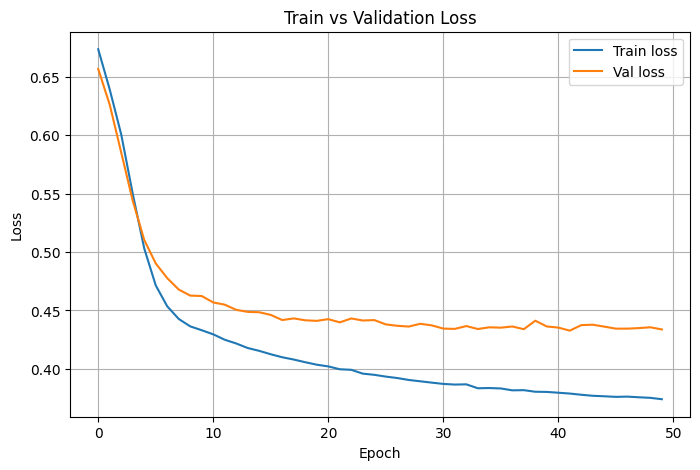

In [12]:
# ==========================================
# 9. Візуалізація кривих втрат
# ==========================================
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# ==========================================
# 10. Оцінка якості моделі
# ==========================================
model.eval()
with torch.no_grad():
    # Проганяємо всі валідаційні дані одним блоком
    val_probs = model(X_val_tensor).cpu().numpy()  # переносимо на CPU для sklearn
    # Перетворюємо ймовірності у 0/1 за порогом 0.5
    val_preds_binary = (val_probs >= 0.5).astype(int).flatten()

# Рахуємо accuracy і детальний звіт
print("Validation accuracy:", accuracy_score(y_val, val_preds_binary))
print("\nClassification report:")
print(classification_report(y_val, val_preds_binary))


Validation accuracy: 0.7988826815642458

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       110
           1       0.82      0.61      0.70        69

    accuracy                           0.80       179
   macro avg       0.81      0.76      0.77       179
weighted avg       0.80      0.80      0.79       179

